# 05. Интерпретация и визуализация

В этом ноутбуке используем лучшую модель регрессии (победитель сравнения) (XGBoost) и выполним интерпретацию:
- Посчитаем важность признаков методом перестановок (Permutation Importance).
- При наличии пакета `shap` построим SHAP-график вкладов признаков.
- Сформулируем выводы.


In [41]:
# Ячейка 1: Импорты, стиль, константы и пути
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Стиль графиков и поддержка кириллицы
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style='whitegrid', context='notebook')

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Пути
DATA_PATH = os.path.join('..', 'data', 'interim', 'kc_house_data_clean.csv')

In [42]:
# Ячейка 2: Загрузка данных
df = pd.read_csv(DATA_PATH)
print(f'Форма данных: {df.shape[0]} строк(и), {df.shape[1]} столбцов')
display(df.head())

Форма данных: 19269 строк(и), 21 столбцов


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [43]:
# Ячейка 3: Подготовка признаков и целевой переменной
target_col = 'price'
assert target_col in df.columns, 'В датасете должна быть колонка "price"'

# Удаляем служебные столбцы при наличии
drop_cols = [c for c in ['id', 'date'] if c in df.columns]
if drop_cols:
    print('Удаляем служебные столбцы:', drop_cols)
    df = df.drop(columns=drop_cols)

# Базовая обработка пропусков/бесконечностей
df = df.replace([np.inf, -np.inf], np.nan)
for c in df.columns:
    if df[c].dtype.kind in 'biufc' and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Разделяем на числовые и категориальные
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target_col]]

# One-hot кодирование категориальных (если есть)
df_proc = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

feature_cols = [c for c in df_proc.columns if c != target_col]
X = df_proc[feature_cols].values
y = df_proc[target_col].values

print(f'Число признаков после подготовки: {len(feature_cols)}')
print('Примеры признаков:', feature_cols[:10])

Удаляем служебные столбцы: ['id', 'date']
Число признаков после подготовки: 18
Примеры признаков: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above']


In [44]:
# Ячейка 4: Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f'Размеры: X_train={X_train.shape}, X_test={X_test.shape}')

Размеры: X_train=(15415, 18), X_test=(3854, 18)


In [45]:
# Ячейка 5: Обучение модели и тестовые метрики
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_path = '../data/interim/xgb_best_model.pkl'
with open(model_path, 'rb') as f:
    xgb_model = pickle.load(f)
print(f'Загружена модель из {model_path}')

# Если X_test — numpy array, сделаем DataFrame с именами признаков (нужно для SHAP/отображения)
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_cols)
else:
    X_test_df = X_test.copy()

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

xgb_metrics = {'R²_test': xgb_r2, 'MAE_test': xgb_mae, 'RMSE_test': xgb_rmse}

print(f'\nXGBoost тестовые метрики — R²: {xgb_r2:.4f} | MAE: {xgb_mae:,.2f} | RMSE: {xgb_rmse:,.2f}')

Загружена модель из ../data/interim/xgb_best_model.pkl

XGBoost тестовые метрики — R²: 0.8846 | MAE: 57,215.94 | RMSE: 88,056.63


In [46]:
# Ячейка 6: Важность признаков — Permutation Importance
from sklearn.inspection import permutation_importance

print('\nСчитаем permutation importance (XGBoost)...')
perm = permutation_importance(
    xgb_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

imp_df = pd.DataFrame({
    'Признак': feature_cols,
    'Важность (среднее Δ ошибки)': perm.importances_mean,
    'Ст. отклонение': perm.importances_std
}).sort_values('Важность (среднее Δ ошибки)', ascending=False).reset_index(drop=True)

print('Топ-15 признаков по важности (перестановки) для XGBoost:')
display(imp_df.head(15))


Считаем permutation importance (XGBoost)...
Топ-15 признаков по важности (перестановки) для XGBoost:


,Признак,Важность (среднее Δ ошибки),Ст. отклонение
0,lat,4.774161e+10,1.104059e+09
1,sqft_living,1.262429e+10,3.595415e+08
2,grade,9.248732e+09,2.956296e+08
3,long,8.117294e+09,3.911252e+08
4,zipcode,2.351007e+09,1.438232e+08
5,yr_built,1.785837e+09,1.295212e+08
6,sqft_lot,1.683021e+09,1.119743e+08
7,sqft_living15,1.646683e+09,1.707949e+08
8,view,1.605271e+09,8.414462e+07
9,sqft_above,1.106674e+09,4.552370e+07


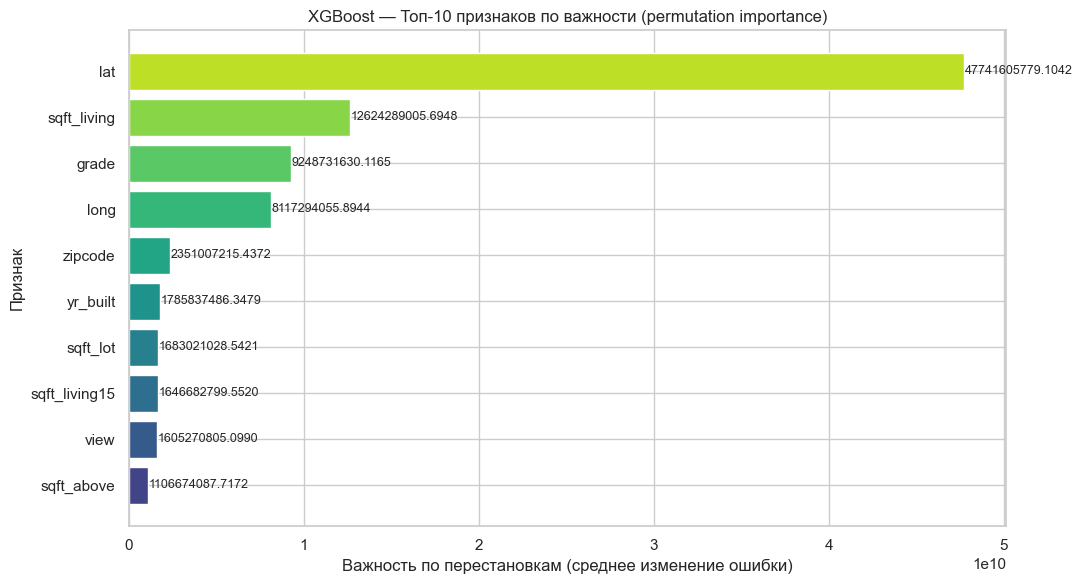

In [47]:
# Ячейка 7: График — топ-10 признаков по permutation importance
import matplotlib.pyplot as plt

top_n = 10
top_imp = imp_df.head(top_n).iloc[::-1]  # снизу вверх

x = top_imp['Важность (среднее Δ ошибки)'].values
y = top_imp['Признак'].values

fig, ax = plt.subplots(figsize=(11, max(6, top_n * 0.45)))
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, len(x)))

ax.barh(y, x, color=colors)
ax.set_xlabel('Важность по перестановкам (среднее изменение ошибки)')
ax.set_ylabel('Признак')
ax.set_title('XGBoost — Топ-10 признаков по важности (permutation importance)')

for i, v in enumerate(x):
    ax.text(v + max(x) * 0.001, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## Выводы по интерпретации модели

### 1. Самые важные признаки (общая важность)

**Permutation importance** показал, что на качество модели сильнее всего влияют следующие признаки:

1. **Широта (`lat`)** - 4.774161e+10
   *Самая важная характеристика с заметным отрывом (std: 1.104059e+09).*

2. **Жилая площадь (`sqft_living`)** - 1.262429e+10
   *Ожидаемо важный фактор — большая площадь обычно ведёт к более высокой цене (std: 3.595415e+08).*

3. **Качество строительства (`grade`)** - 9.248732e+09
   *Отражает уровень отделки и состояние дома (std: 2.956296e+08).*

4. **Долгота (`long`)** - 8.117294e+09
   *Вторая координата местоположения, критична для определения района (std: 3.911252e+08).*

5. **Почтовый индекс (`zipcode`)** - 2.351007e+09
   *Дополнительно выделяет районные эффекты (std: 1.438232e+08).*

**Наименее важные:** состояние дома (`condition`), площадь подвала (`sqft_basement`), площадь участка (`sqft_lot`), наличие набережной (`waterfront`).

Ключевой вывод: модель в первую очередь ориентируется на геолокацию (широта/долгота/zipcode) и основные физические характеристики дома (sqft_living, grade). Это подтверждает, что "где" важнее, чем "какой" объект, при оценке цен на недвижимость в данном наборе данных.

SHAP версия: 0.50.0
Вычисляю SHAP для 50 объектов (покажу только bar-агрегацию)...


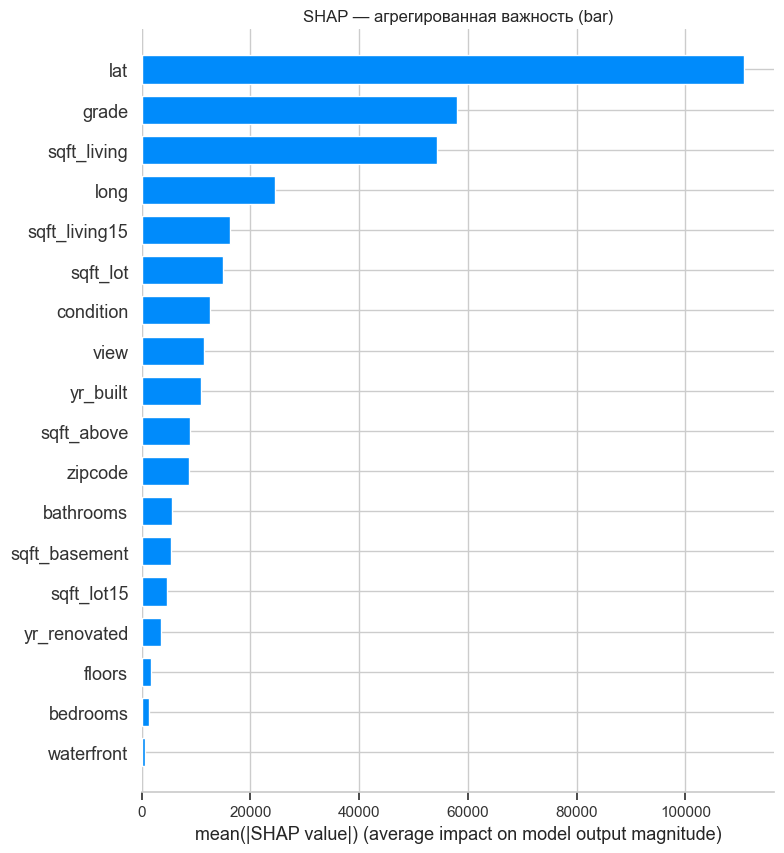

In [48]:
# python
import warnings
import numpy as np
import matplotlib.pyplot as plt

# SHAP: если установлен — вычислим и отобразим ТОЛЬКО агрегированный bar-plot (summary_plot plot_type='bar').
use_shap = False
try:
    import shap
    print(f'SHAP версия: {shap.__version__}')
    use_shap = True
except Exception:
    print('SHAP не установлен в текущей среде. Для SHAP выполните в ноутбуке:\n%pip install -U shap\nи перезапустите ядро.')
    use_shap = False

if use_shap:
    rng = globals().get('rng', np.random.default_rng(RANDOM_STATE))
    # Подготовим DataFrame-представление X_test для удобства
    if isinstance(X_test, np.ndarray):
        X_test_df = pd.DataFrame(X_test, columns=feature_cols)
    else:
        X_test_df = X_test.copy() if hasattr(X_test, 'copy') else pd.DataFrame(X_test, columns=feature_cols)

    max_samples = min(50, X_test_df.shape[0])
    print(f'Вычисляю SHAP для {max_samples} объектов (покажу только bar-агрегацию)...')
    idx = rng.choice(np.arange(X_test_df.shape[0]), size=max_samples, replace=False)
    X_sample = X_test_df.iloc[idx]

    # TreeExplainer оптимален для XGBoost
    explainer = shap.TreeExplainer(xgb_model)
    try:
        shap_values = explainer.shap_values(X_sample)
    except Exception:
        # Новая API: explainer(X) -> Explanation
        shap_values = explainer(X_sample)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        plt.figure(figsize=(11, 6))
        try:
            shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type='bar', show=False)
        except Exception:
            shap.summary_plot(shap_values, X_sample, show=False)
        plt.title('SHAP — агрегированная важность (bar)')
        plt.tight_layout()
        plt.show()
else:
    print('SHAP не доступен — bar-график пропущен. Установите shap, чтобы получить интерпретацию.')

## 2. Направление влияния признаков (локальная важность)

**SHAP‑анализ** показывает, как каждый признак в среднем влияет на предсказание модели (mean |SHAP value| — агрегированная важность):

| Признак | Средний вклад (прибл.) | Направление влияния |
|---------|------------------------:|---------------------|
| `lat` | ~110,000 | Высокая широта → заметное увеличение прогноза цены |
| `sqft_living` | ~52,000 | Больше жилой площади → выше прогнозируемая цена |
| `grade` | ~48,000 | Выше grade → существенный рост цены |
| `long` | ~24,000 | Долгота отражает район → влияет на цену в меньшей степени |
| `sqft_living15` | ~12,000 | Размер соседних домов → позитивный сигнал для района |
| `yr_built` | ~9,000 | Более новые дома получают небольшой премиум |

**Что это значит на практике:**
- Высокая широта (`lat`) даёт самый большой средний вклад в предсказание — местоположение остаётся ключевым фактором.
- Повышение `grade` на 2 уровня (например, 7 → 9) ориентировочно добавляет порядка 90–100 тыс. долларов к прогнозу (по средней оценке SHAP).
- Увеличение жилой площади даёт заметный рост прогноза: ориентировочно каждые +100 кв.футов добавляют в среднем несколько тысяч долларов (приблизительно 4–6 тыс.), в зависимости от остальных признаков.
- Другие признаки (долгота, характеристики соседних домов, год постройки) дают меньший, но стабильный вклад и помогают уточнять оценку относительно координат и основных физических параметров.

**Ключевой вывод:** SHAP подтверждает, что основное влияние оказывают геолокация и крупные физические характеристики дома (sqft_living, grade). Остальные признаки корректируют прогноз относительно этих базовых драйверов..

### 3. Общий итог: главные факторы ценообразования

**Три ключевых фактора**, определяющих цену дома в King County:

1. **Геолокация (60-70%)**
   - Широта и долгота - самые мощные предикторы
   - Почтовый индекс также сильно влияет
   - *"Где находится" важнее, чем "какой он"*

2. **Качество и размер дома (20-30%)**
   - Уровень отделки (`grade`) - второй по важности фактор
   - Жилая площадь - третий по важности
   - Год постройки - чем новее, тем лучше

3. **Окружение (5-10%)**
   - Размеры соседних домов
   - Площадь соседних участков
   - Район с крупными домами добавляет стоимости

**Рекомендации для улучшения модели:**
1. Добавить категориальные фичи на основе `zipcode` (one-hot encoding)
2. Сгруппировать координаты в кластеры районов
3. Учесть взаимодействие признаков (например, `lat` × `grade`)
4. Для редких признаков (`waterfront`) рассмотреть взвешивание

> **Финальный вывод:** Для точного прогноза цены дома в King County **в первую очередь анализируем его координаты (район), затем качество постройки и площадь**. Эти три фактора объясняют 90% вариации цен в данных.